# Numpy as numerical solver

This week, we will continue to work with `numpy`. This week, we will learn about new tools to solve problems and equations!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Number representation in computers

Numbers are represented in memory as a series of bits (0s and 1s). Therefore, **given a fixed number of bits, only a finite count of possible numbers can be stored in memory.** With 8 bits (a byte), for example, only $2^8$ different combinations are possible: therefore, 8-bits can store only 256 different numbers. With 32 bits, $2^{32}$ combinations are possible: that's a much larger number (4294967296), but still - it is a finite number. 

Clever strategies have been developed to deal with this limitation. If you want to know more, visit the [master lecture](https://fabienmaussion.info/scientific_programming/week_04/02-Numbers.html) on the topic. For now, let me convey the most important messages to remember.

**⯈ Integer datatypes in numpy have a validity range:**

In [2]:
np.iinfo(np.int32)

iinfo(min=-2147483648, max=2147483647, dtype=int32)

The range of validity is easy to understand. Indeed, the first bit is used to store the sign information("1" for "+", "0" for "-"), which leaves us with $2^{31} = 2147483648$ possibilities.

Concretely, this means that the following can happen:

In [3]:
n = np.array([2147483647], dtype=np.int32)
n + 1

array([-2147483648], dtype=int32)

This is called an **overflow**.

**⯈ Integer datatypes are always exact** (when they don't overflow)

Unlike floats, when entering a number as integer in numpy, you can be sure that the number is exact:

In [4]:
12 - 24 // 2

0

This is *really* a 0 of type integer (and not an approximation of it).

**⯈ Float datatypes are almost always inexact**

Numbers in the real coordinate space are infinite, and yet in computers we have to represent them in a finite space. Therefore, numpy (and the vast majority of scientific software) use a standard called [IEEE 754](https://en.wikipedia.org/wiki/IEEE_754) for floating-point arithmetic.

With the floating-point standard, "real" numbers are thereby converted to the closest possible "floating point" number. Most of the time we don't see it, unless we ask very insistingly: 

In [5]:
a = 0.1
print(f'{a}')  # print a
print(f'{a:.9f}')  # print a with 9 decimal places
print(f'{a:.18f}')  # print a with 18 decimal places

0.1
0.100000000
0.100000000000000006


Sometimes, we don't even have to ask politely to see it:

In [6]:
1 / 10 * 3

0.30000000000000004

**⯈ Float datatypes have a relative precision model**

This is one of the most clever idea of the IEEE 754 standard: in absolute values, small number are more precise than large numbers. This can lead to the following confusing behavior:

In [7]:
.99 == .98

False

This is expected: `0.99` is not the same number as `0.98`. But what about these two:

In [8]:
999999999999999.99 == 999999999999999.98

True

Also **not** the same numbers, yet the computer thinks they are! This is because `0.01` is below the accuracy of large floating point numbers.

**⯈ There are ways to deal with this problem**

Let's say you would like to compare numbers:

In [9]:
a = np.ones(3)
a = a / 10 * [1, 2, 3]
a

array([0.1, 0.2, 0.3])

In [10]:
b = np.array([0.1, 0.2, 0.3])
b

array([0.1, 0.2, 0.3])

In [11]:
a == b

array([ True,  True, False])

That's bad, right? Instead, use:

In [12]:
np.isclose(a, b)

array([ True,  True,  True])

There are many other things to learn about floating point numbers, but we will get back to this in the master lecture. You can have a [look at it](https://fabienmaussion.info/scientific_programming/week_04/02-Numbers.html#number-representation-in-computers) if you are interested!

**For now, remember about these pitfalls when you want to compare numbers between each other.**

## Discretization 

Because of the limitations explained above, computers cannot represent continuous functions. Instead, we have to rely on **discrete domains** which have a finite number of elements.  See the following example:

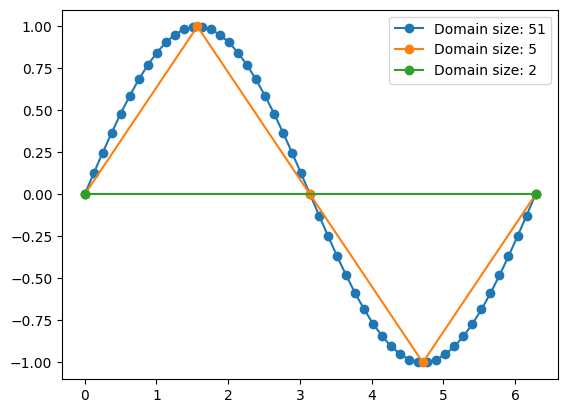

In [13]:
x1 = np.linspace(0, 2 * np.pi, 51)
x2 = np.linspace(0, 2 * np.pi, 5)
x3 = np.linspace(0, 2 * np.pi, 2)
plt.plot(x1, np.sin(x1), '-o', label='Domain size: 51');
plt.plot(x2, np.sin(x2), '-o', label='Domain size: 5');
plt.plot(x3, np.sin(x3), '-o', label='Domain size: 2');
plt.legend();

Same mathematical function (`sin`), different discretizations. When solving math or physics problems, its the task of the programmer to decide the correct coordinates depending on the question to address or other considerations (e.g. performance). Numpy has two main functions to create discrete coordinates:

- [np.arange](https://numpy.org/doc/stable/reference/generated/numpy.arange.html) when you know the start, end, and step size but not the domain size
- [np.linspace](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html) when you know the start, end, and domain size but not the step size

````{warning}
The default integer type on Windows machines is `np.int32` ([link](https://github.com/numpy/numpy/issues/9464)). This means that the default `dtype` for arrays created with `np.arange` or `np.array` with integers as input will be `np.int32`!

i.e., on Windows, the following behavior is very likely to occur:

```python
>>> a = np.arange(212, 219, step=2)
>>> a
array([212, 214, 216, 218], dtype=int32)
>>> a ** 4
array([ 2019963136,  2097273616, -2118184960, -2036436720], dtype=int32)
```

**A silent overflow**!!! Always remember this when using `np.arange` on Windows, and prefer to explicitly set the dtype to `int64` or `float64`.
````

## Find occurences of values in numpy arrays 

Let's stick with our sinus function example:

In [14]:
x = np.linspace(0, 2 * np.pi, 101)
y = np.sin(x)
y

array([ 0.00000000e+00,  6.27905195e-02,  1.25333234e-01,  1.87381315e-01,
        2.48689887e-01,  3.09016994e-01,  3.68124553e-01,  4.25779292e-01,
        4.81753674e-01,  5.35826795e-01,  5.87785252e-01,  6.37423990e-01,
        6.84547106e-01,  7.28968627e-01,  7.70513243e-01,  8.09016994e-01,
        8.44327926e-01,  8.76306680e-01,  9.04827052e-01,  9.29776486e-01,
        9.51056516e-01,  9.68583161e-01,  9.82287251e-01,  9.92114701e-01,
        9.98026728e-01,  1.00000000e+00,  9.98026728e-01,  9.92114701e-01,
        9.82287251e-01,  9.68583161e-01,  9.51056516e-01,  9.29776486e-01,
        9.04827052e-01,  8.76306680e-01,  8.44327926e-01,  8.09016994e-01,
        7.70513243e-01,  7.28968627e-01,  6.84547106e-01,  6.37423990e-01,
        5.87785252e-01,  5.35826795e-01,  4.81753674e-01,  4.25779292e-01,
        3.68124553e-01,  3.09016994e-01,  2.48689887e-01,  1.87381315e-01,
        1.25333234e-01,  6.27905195e-02, -3.21624530e-16, -6.27905195e-02,
       -1.25333234e-01, -

Let's say we would like to know the maximum value of our data. We do this with:

In [15]:
np.max(y)

np.float64(1.0)

Now, we would like to know *where* this happens, i.e. the associated coordinate where this happens. There are several ways to achieve this (can you think of one?), but the best is to use [np.argmax()](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html):

In [16]:
np.argmax(y)

np.int64(25)

What is this number? This is the index at which the maximum is reached - you can verify this easily with:

In [17]:
am = np.argmax(y)
print(y[am], x[am])

1.0 1.5707963267948968


Similarly, there are the functions [nanargmax](https://numpy.org/doc/stable/reference/generated/numpy.nanargmax.html), [argmin](https://numpy.org/doc/stable/reference/generated/numpy.argmin.html), etc.

Now, let's say we would like to know where (at which indices) the values of `y` are below a certain threshold (e.g. 0). You already know how to fetch them:

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]


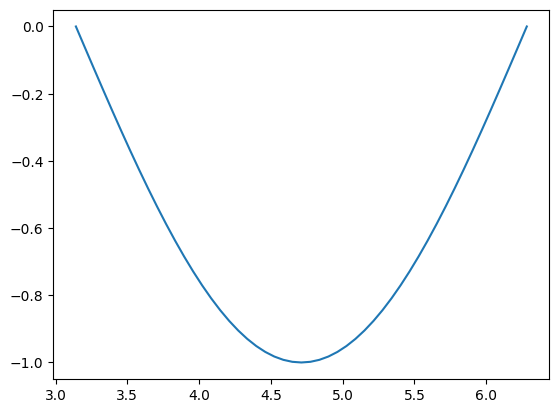

In [18]:
below_zero = y < 0
print(below_zero)
plt.plot(x[below_zero], y[below_zero]);

But this does not really answer the question of *at which indices* this occurs. For this, we have to use the function [np.nonzero()](https://numpy.org/doc/stable/reference/generated/numpy.nonzero.html):

In [19]:
ok = np.nonzero(below_zero)
type(ok), len(ok), len(ok[0])

(tuple, 1, 51)

`np.nonzero` always returns a tuple of size `ndim` (here 1), and the n-th element of the tuple returns a list of the indices in the array where the condition is true (non zero):

In [20]:
ok[0]

array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100])

Therefore, this here is equivalent to the plot above (albeit a bit slower):

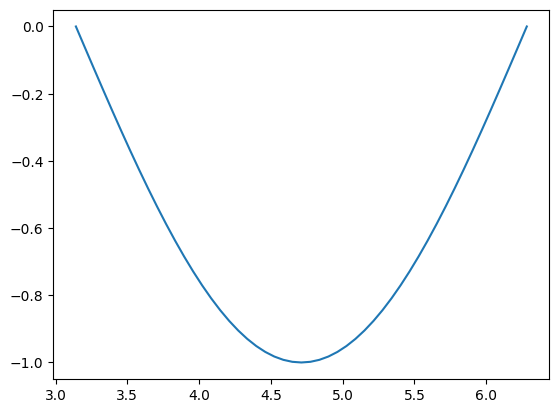

In [21]:
plt.plot(x[ok], y[ok]);

This information can be useful in certain situations, for example when you want to know when a value is reached for the first time:

In [22]:
print(f'The first time at which y becomes negative occurs at x = {x[ok[0][0]]}')

The first time at which y becomes negative occurs at x = 3.1415926535897936


## Difference equations

Difference equations are equations involving the differences between successive values of a function of a discrete variable. 

Let's start with a trivial example (source: [Joakim Sundnes](https://sundnes.github.io/solving_odes_in_python/ode_book.pdf)). 

Consider the problem of computing how an invested sum of money grows over time. In its simplest form, this problem can be written as putting
$x_0$ money in a bank at year 0, with interest rate $p$ percent per year. What is then the value after n years? 

You may recall from high school mathematics that the solution to this problem is given by the formula $x_n = x_0 (1 + p / 100)^n$ so there is really no need to formulate and solve the problem as a difference equation. However, very simple generalizations, such as a non-constant interest rate, makes this formula difficult to apply, while a formulation based on a difference equation will still be applicable. 

To formulate the problem as a difference equation, we use the fact that the amount $x_n$ at year $n$ is simply the amount at year $n - 1$ plus the interest for year $n - 1$. This gives the following relation between $x_n$ and $x_{n-1}$:

$$x_n = x_{n-1} + \frac{p}{100} x_{n-1}$$

Let's solve this problem numerically:

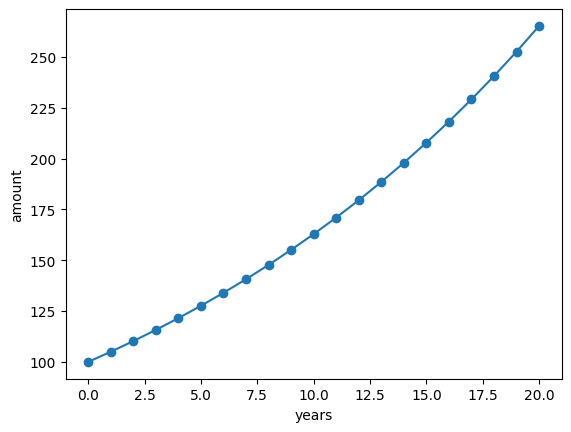

In [23]:
x0 = 100  # initial amount
p = 5  # interest rate
n = 20  # number of years

# Data containter
x = np.zeros(n + 1)

# Initial state
x[0] = x0

# Iterative solving
for n in range(1, n + 1):
    x[n] = x[n - 1] + (p / 100) * x[n - 1]

plt.plot(x, '-o')
plt.xlabel('years'); plt.ylabel('amount');

This is a simple example. But **iterative solving** (where a future state depends on past states) **is at the core of a wide range of modern numerical models** (including weather forecasting and climate models).

To continue the illustration, let's take an other example: logistic growth. Logistic growth often happens in ecology when a population grows exponentially until a limiting factor is reached: for example limited resources, that can only support a finite number $R$ of individuals. Initially, when resources are abundant, the growth is exponential. According to the difference equation introduced above:

$$x_n = x_{n-1} + \frac{r}{100} x_{n-1}$$

With $r$ the growth rate per year in %. To enforce the growth limit as $x_n \rightarrow R$, $r$ must decay to zero as $x_n$ approaches $R$. The simplest variation of $r(n)$ is linear:

$$r(n) = \rho \left(1 - \frac{x_n}{R} \right)$$

Where $\rho$ is the initial growth rate and $R$ the limit of individuals. This formulation translates into the following difference equation:

$$x_n = x_{n-1} + \frac{\rho}{100} x_{n-1} \left(1 - \frac{x_{n-1}}{R} \right)$$

Let's convert this to code:

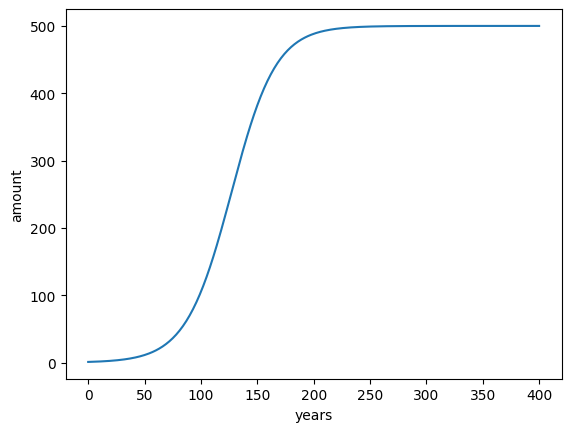

In [24]:
x0 = 1  # initial population
rho = 5  # growth rate in %
r = 500  # max population (carrying capacity)
n = 400  # number of years

# Data container
time = np.arange(n + 1)
x = np.zeros(n + 1)

# Initial state
x[0] = x0

# Iterative solving
for n in time[1:]:
    x[n] = x[n - 1] + (rho / 100) * x[n - 1] * (1 - x[n - 1] / r)

plt.plot(time, x)
plt.xlabel('years'); plt.ylabel('amount');

Nice! Now, sometimes, one wants to stop the simulation when it has *converged*, i.e. when the data does not change much with anymore. In this case, the number of years that the simulation will take is unknown since we cannot predict when this will happen. We have to use other strategies:

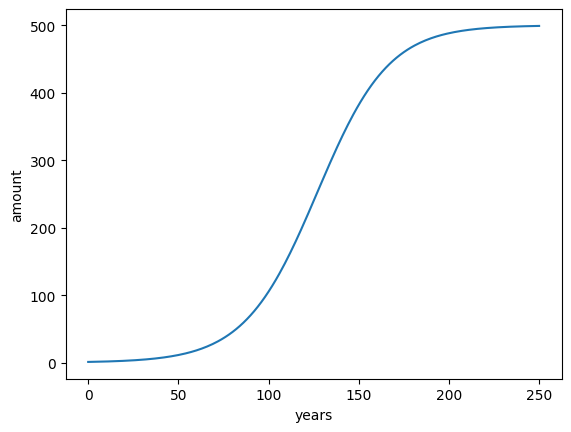

In [25]:
x0 = 1  # initial population
rho = 5  # growth rate in %
r = 500  # max population (carrying capacity)
threshold_growth_rate = 0.01  # stop the simulation when growth rate is below 0.01%
max_years = 500  # safegard: stop the simulation anyways at this date

# Data ontainers - size will grow with time
time = [0]
x = [x0]

growth_rate = rho  # initial growth rate (will be updated)
n = 0  # counter (will be updated)

# Iterative solving
while growth_rate > threshold_growth_rate and n <= max_years:
    n += 1
    x = np.append(x, x[n - 1] + (rho / 100) * x[n - 1] * (1 - x[n - 1] / r))
    time = np.append(time, n)

    # Compute actual growth rate from data to see if we have to stop
    growth_rate = (x[n] - x[n - 1]) / x[n - 1] * 100

plt.plot(time, x)
plt.xlabel('years'); plt.ylabel('amount');

We made use of three main strategies:
- instead of a `for` loop, we use a `while` loop and stop the simulation when a threshold is reached
- in order to avoid infinite loops, we make sure we have an iteration limit we won't exceed
- instead of generating data container of predefined length that we fill up, we use `np.append` to extend the array as time advances

**Exercise: note that you can achieve the same result with a for loop and a `break` statement - would you like to try coding it?**

(numpy-algebra)=
## Linear algebra with numpy 

You already know that you can create `ndarrays` of any dimensions in numpy. For example, an `ndarray` of dimensions 2: 

In [26]:
a = np.array([[1, 2, 3], [4, 5, 6]])
a

array([[1, 2, 3],
       [4, 5, 6]])

Like for vectors, arithmetic operations are occurring element-wise:

In [27]:
a + 1

array([[2, 3, 4],
       [5, 6, 7]])

When doing arithmetics on two arrays the rules of [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) apply. For now, you need to remember that if the arrays are of the same dimension, operations will also be applies element-wise: 

In [28]:
(a + 1) * a

array([[ 2,  6, 12],
       [20, 30, 42]])

Therefore, `ndarrays` aren't really "vectors" or "matrices" in the sense you have learned in math class. In my work for example I almost never think in terms of matrices, but I think of `ndarrays` much more in terms of "data containers" or "images" (for example when I plot meteorological data on a map). 

This doesn't mean that numpy cannot be used for linear algebra. In fact, [an entire module](https://numpy.org/doc/stable/reference/routines.linalg.html) of numpy deals with linear algebra. In this class we will learn only the very basics of it.

To compute [matrix multiplications](https://en.wikipedia.org/wiki/Matrix_multiplication) in numpy (as opposed to element-wise multiplication), we can use the `@` (matmul) operator:

In [29]:
a @ np.array([1, 2, 3])  # matrix multiplication

array([14, 32])

**Exercise: on a sheet of paper, verify that the result is correct.**

With matrix multiplication, the dimensions matter. For example:

In [30]:
a = np.array([1, 2, 3]).reshape(1, 3)  # 1 rows, 3 columns
b = np.array([1, 2, 3]).reshape(3, 1)  # 3 rows, 1 column
print(a)
print('@')
print(b)
print('=')
print(a @ b)  # 1 row, 1 column

[[1 2 3]]
@
[[1]
 [2]
 [3]]
=
[[14]]


In [31]:
a = np.array([1, 2, 3]).reshape(3, 1)  # 3 rows, 1 column
b = np.array([1, 2, 3]).reshape(1, 3)  # 1 row, 3 columns
print(a)
print('@')
print(b)
print('=')
print(a @ b)  # 3 rows, 3 columns

[[1]
 [2]
 [3]]
@
[[1 2 3]]
=
[[1 2 3]
 [2 4 6]
 [3 6 9]]


Matrices can be transposed with the `.T` attribute:

In [32]:
a = np.array([[1, 2], [3, 4]])
a.T

array([[1, 3],
       [2, 4]])

**Exercise: with two arbitrary quadratic matrices `a` and `b` of the same size, verify that $(A B)^T = B^T A^T$**

If a matrix is invertible, you can compute its inverse with:

In [33]:
a_inv = np.linalg.inv(a)
a_inv

array([[-2. ,  1. ],
       [ 1.5, -0.5]])

**Exercise: with the help of a python interpreter or a piece of paper, verify that `a_inv` is indeed the inverse of `a`.**

## Learning checklist 

<label><input type="checkbox" id="week05_01" class="box"> I understand that floating point numbers in computers are almost always inexact. I know that their accuracy depends on their type and the numbers themselves.</input></label><br>
<label><input type="checkbox" id="week05_01" class="box"> I am aware of the function `np.isclose()` to help me deal with floating point accuracy.</input></label><br>
<label><input type="checkbox" id="week05_01" class="box"> I can solve simple iterative problems with numpy: either we containers of predefined size or with containers growing with time.</input></label><br>
<label><input type="checkbox" id="week05_01" class="box"> I know how to compute simple linear algebra operations on matrices with numpy: matrix multiplication, transpose, inversion.</input></label><br>